In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory




# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from termcolor import colored

In [3]:
path = ''
image_path = os.path.join(path, '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/')
mask_path = os.path.join(path, '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/')

In [4]:
image_list = os.listdir(image_path)
im_list = image_list
mask_list = os.listdir(mask_path)

In [5]:
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in im_list]

for x in range(0,400):
    mask_list[x] = mask_list[x][:-4] + '.png'

Text(0.5, 1.0, 'Segmentation')

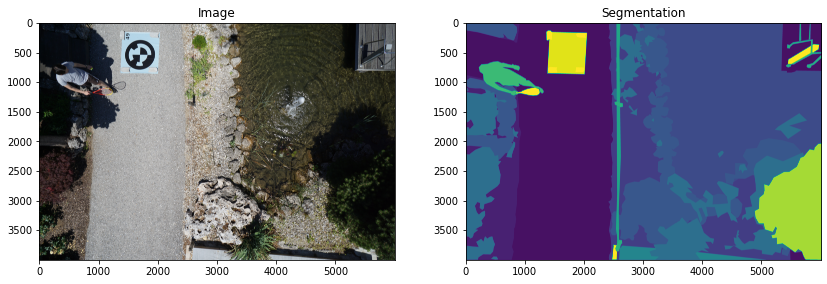

In [6]:
N = 56
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [7]:
import tensorflow as tf
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

2022-09-29 06:25:01.087357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 06:25:01.203805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 06:25:01.204776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 06:25:01.207677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/001.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/002.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/002.png'>)


In [8]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/208.jpg', shape=(), dtype=string)
tf.Tensor(b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/208.png', shape=(), dtype=string)


In [9]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        result.append(descriptors)
    return result

In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  3,      
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)      
    
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
input_size=(256, 256, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 256, 256, 3)], 0],
            ['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

#comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 256, 256, 3)], 0],
            ['Conv2D', (None, 256, 256, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 256, 256, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 256, 256, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 128, 128, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
#comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 256, 256, 3)], 0]
['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)]

Block 2:
['InputLayer', [(None, 256, 256, 3)], 0]
['Conv2D', (None, 256, 256, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 256, 256, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 256, 256, 1024), 0, 0.1]
['MaxPooling2D', (None, 128, 128, 1024), 0, (2, 2)]


In [13]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,    
                 3,   
                 strides=2,
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   
                 3,     
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  
                 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [14]:
input_size1=(32, 32, 256)
input_size2 = (64, 64, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 32, 32, 256)], 0],
            ['Conv2DTranspose', (None, 64, 64, 32), 73760],
            ['InputLayer', [(None, 64, 64, 128)], 0],
            ['Concatenate', (None, 64, 64, 160), 0],
            ['Conv2D', (None, 64, 64, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 64, 64, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

#comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 32, 32, 256)], 0]
['Conv2DTranspose', (None, 64, 64, 32), 73760]
['InputLayer', [(None, 64, 64, 128)], 0]
['Concatenate', (None, 64, 64, 160), 0]
['Conv2D', (None, 64, 64, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 64, 64, 32), 9248, 'same', 'relu', 'HeNormal']


In [15]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=None) 
    
    ublock6 = upsampling_block(cblock5[0],cblock4[1] ,  n_filters * 8)
     
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [16]:
unet_model_output = [['InputLayer', [(None, 256, 256, 3)], 0],
['Conv2D', (None, 256, 256, 32), 896, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 128, 128, 32), 0, (2, 2)],
['Conv2D', (None, 128, 128, 64), 18496, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 128, 128, 64), 36928, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 64, 64, 64), 0, (2, 2)],
['Conv2D', (None, 64, 64, 128), 73856, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 64, 64, 128), 147584, 'same', 'relu', 'HeNormal'],
['MaxPooling2D', (None, 32, 32, 128), 0, (2, 2)],
['Conv2D', (None, 32, 32, 256), 295168, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 32, 32, 256), 590080, 'same', 'relu', 'HeNormal'],
['Dropout', (None, 32, 32, 256), 0, 0.3],
['MaxPooling2D', (None, 16, 16, 256), 0, (2, 2)],
['Conv2D', (None, 16, 16, 512), 1180160, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 16, 16, 512), 2359808, 'same', 'relu', 'HeNormal'],
['Dropout', (None, 16, 16, 512), 0, 0.3],
['Conv2DTranspose', (None, 32, 32, 256), 1179904],
['Concatenate', (None, 32, 32, 512), 0],
['Conv2D', (None, 32, 32, 256), 1179904, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 32, 32, 256), 590080, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 64, 64, 128), 295040],
['Concatenate', (None, 64, 64, 256), 0],
['Conv2D', (None, 64, 64, 128), 295040, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 64, 64, 128), 147584, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 128, 128, 64), 73792],
['Concatenate', (None, 128, 128, 128), 0],
['Conv2D', (None, 128, 128, 64), 73792, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 128, 128, 64), 36928, 'same', 'relu', 'HeNormal'],
['Conv2DTranspose', (None, 256, 256, 32), 18464],
['Concatenate', (None, 256, 256, 64), 0],
['Conv2D', (None, 256, 256, 32), 18464, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 32), 9248, 'same', 'relu', 'HeNormal'],
['Conv2D', (None, 256, 256, 23), 759, 'same', 'linear', 'GlorotUniform']]

In [17]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
#comparator(summary(unet), unet_model_output)

In [18]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [19]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2022-09-29 06:25:07.274064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...


(4000, 6000, 1)


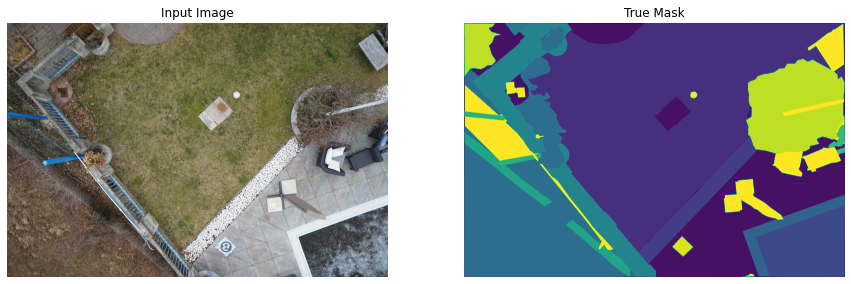

In [21]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

Cleanup called...
Cleanup called...


(256, 256, 1)


Cleanup called...
Cleanup called...


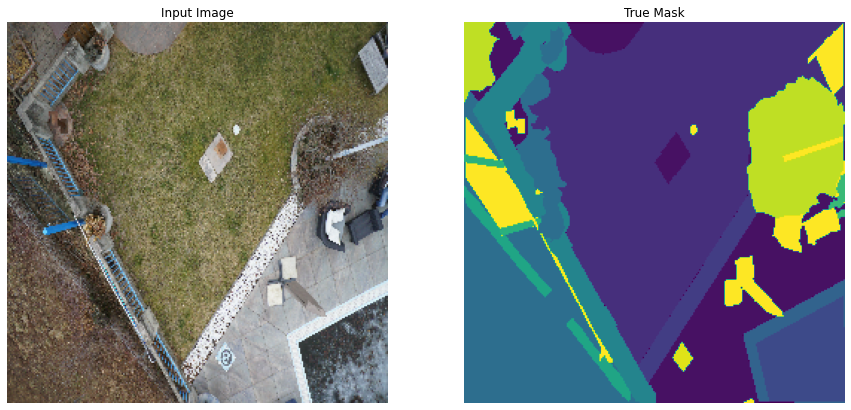

In [22]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [24]:
EPOCHS = 350
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

processed_image_ds=processed_image_ds.shuffle(BUFFER_SIZE)

ts=len(processed_image_ds)
val_dataset=processed_image_ds.skip(int(ts*0.8))
train_dataset=processed_image_ds.take(int(ts*0.8))

print(len(val_dataset))
print(len(train_dataset))

val_dataset.batch(BATCH_SIZE)
train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(len(val_dataset))
print(len(train_dataset))
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[es])

80
320
3
10
(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/350


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-09-29 06:25:29.245632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 17 of 500
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-09-29 06:25:39.293411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 34 of 500
Cleanup called...
Cleanup called...
Cleanup called...
Clea

10/10 [==============================] - ETA: 0s - loss: 3.9075 - accuracy: 0.2299

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-09-29 06:29:43.123749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19 of 500
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-09-29 06:29:52.292918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 38 of 500
Clea

10/10 [==============================] - 471s 24s/step - loss: 3.9075 - accuracy: 0.2299 - val_loss: 2.7379 - val_accuracy: 0.3257
Epoch 2/350
10/10 [==============================] - 4s 364ms/step - loss: 2.5549 - accuracy: 0.3713 - val_loss: 2.3307 - val_accuracy: 0.3488
Epoch 3/350
10/10 [==============================] - 4s 363ms/step - loss: 2.2692 - accuracy: 0.3805 - val_loss: 2.1588 - val_accuracy: 0.3497
Epoch 4/350
10/10 [==============================] - 4s 366ms/step - loss: 2.1497 - accuracy: 0.3813 - val_loss: 2.0673 - val_accuracy: 0.3494
Epoch 5/350
10/10 [==============================] - 4s 370ms/step - loss: 2.0969 - accuracy: 0.3811 - val_loss: 2.0178 - val_accuracy: 0.3504
Epoch 6/350
10/10 [==============================] - 4s 364ms/step - loss: 2.0451 - accuracy: 0.3828 - val_loss: 1.9896 - val_accuracy: 0.3529
Epoch 7/350
10/10 [==============================] - 4s 367ms/step - loss: 2.0050 - accuracy: 0.3867 - val_loss: 1.9377 - val_accuracy: 0.3557
Epoch 8/350

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

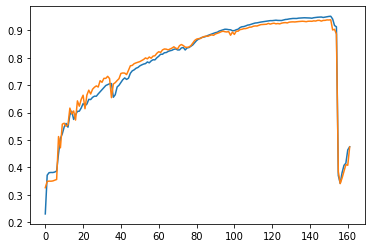

In [29]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])

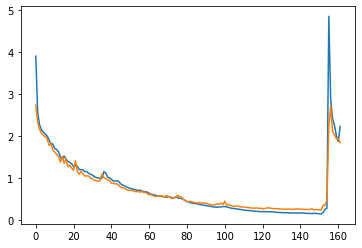

In [30]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])

In [31]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

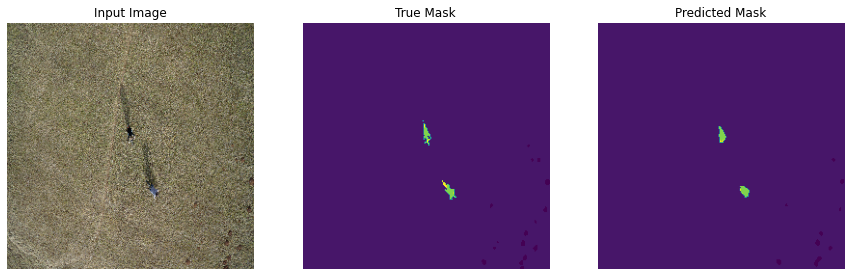

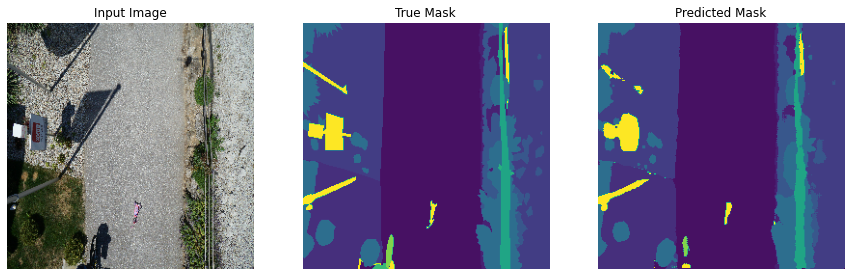

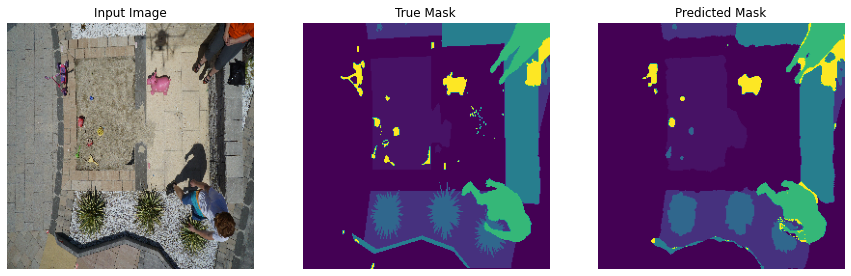

In [37]:
show_predictions(val_dataset, 3)